# Gaussian Process Regression


**Gaussian Process Regression (GPR)** is a non-parametric approach to describe the relationships between variables without specifying the underlying distribution. By choosing Gaussian distributions to model the data, you benefit from their properties, for example that the marginal and conditional distributions are also Gaussian [1]. 


## Gaussian Process

A **Gaussian Process (GP)** is a generalization of a multivariate Gaussian distribution to *infinite dimension* and used to describe a distribution over functions. It defines a prior distribution over functions from which a posterior distribution can be inferred when data is observed.
A GP is completely specified by a mean function $m(x)$ and a covariance function $k(x,x')$ of a real process $f(x)$:    

$$f(x) \sim GP(m(x),k(x,x')).$$     
Usually, the mean value is set to $m(x)=0$ since the GP is flexible enough to model the mean arbitrarily well.
The function values $f(x_1),...,f(x_n)$ are jointly Gaussian, corresponding to any number of input points $n$ [1,2,3]. 


## Kernels

**Kernels** are used as *similarity measure* between objects and define the covariance matrix $\Sigma$. A kernel $k$ is a positive definite kernel function and describes the shape of the distribution as well as characteristics of the function we want to predict. If two points $x$ and $x'$ are deemed by the kernel to be similar, then we expect the output of the function at those points to be similar, too. The kernel function $k$ is a real-valued function of two arguments, $k(x,x') \in \mathbb{R}$. To retrieve the covariance matrix $\Sigma$, we evaluate $k$ on each pairwise combination of the set of points, $k: \mathbb{R}^n \times \mathbb{R}^n \rightarrow \mathbb{R},~ \Sigma = Cov(X,X') = k(x,x')$.  
The most common kernel functions are the following:  

* Radial Basis Function (RBF): $k(x,x')= \sigma^2 exp(- \frac{||x-x'||^2}{2\ell^2}) $  
The RBF kernel is a stationary kernel, hence it is invariant to translations and the covariance between two points depends only on their relative positions. Scale factor $\sigma^2$ is the variance controlling vertical variation, and describing the average distance of the function away from its mean. Parameter $\ell$ determines the horizontal lengthscale ober which the function varies, and determines the reach of influence on the neighbors. 


* Linear: $k(x,x') = \sigma_b^2 + \sigma^2(x-c)(x'-c)$  
The linear kernel is a non-stationary kernel, so the covariance between two points depends on their absolute positions. Parameter $c$ determines the point on which all posterior functions hinge. The constant variance $\sigma_b$ describes how far from 0 the height of the function will be at zero, hence adding an uncertain offset to the model [2,4].


## Prior

We define the **prior** as a GP over the test set $X_*$, where each test point is treated as a random variable. In our example, we choose $|X_*|=N=50$ linearly-spaced values from 0 to 15 as test set to get the prior $P_{X_*}$ before any data is observed. The prior has dimensionality $N$ and revolves around $\mu=0$. The covariance matrix $\Sigma_{**}$ is computed by applying the kernel function $k$ to the test points $X_*$, $\Sigma_{**} = k(X_*,X_*)$. 
To demonstrate realizations of a GP we implement the prior distribution as previously described with following hyperparameters:  
* RBF: $\sigma^2 = 0.5,~ \ell = 2$  
* Linear: $\sigma^2 = 0.5,~ \sigma_b = 2,~ c = 0.5$  

and generate a random Gaussian vector $f_* \sim \mathcal{N}(\mu, k(X_*,X_*)) = \mathcal{N}(0,\Sigma_{**})$ to sample five functions from each Prior.

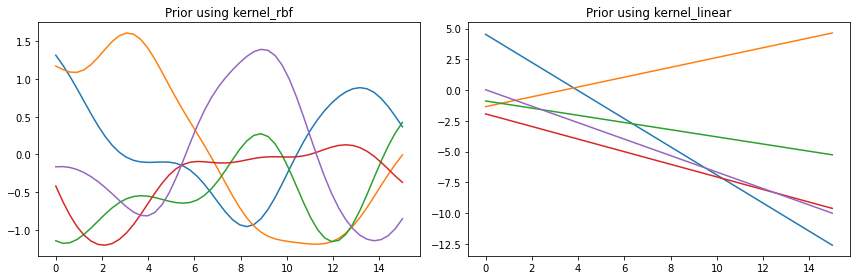

In [3]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt



# Kernel functions
def kernel_rbf(x, y, param):
    variance = param['var']
    lengthscale = param['ell']
    # Euclidean distance between points
    eucdist = np.sum(x**2,1).reshape(-1,1) + np.sum(y**2,1) - 2*np.dot(x, y.T)
    return variance * np.exp(-0.5 * eucdist * 1/(lengthscale**2))
    
    
def kernel_linear(x, y, param):
    variance = param['var']
    variance_b = param['var_b']
    offset = param['off']
    return variance_b + variance * np.dot((x-offset), (y-offset).T)



# define all parameters for all kernels
params = {'var': 0.5,
          'ell': 2,        # larger l -> less wiggles
          'var_b': 2,
          'off': 0.5}


# Test Data: N points from 0 to 15
N_s = 50
X_s = np.linspace(0, 15, N_s).reshape(-1,1)



# Priors using RBF and linear kernel
plt.figure(figsize=(12, 4))

for i, kernel in enumerate([kernel_rbf, kernel_linear]):
    # compute mean and covariance
    mu_prior = np.zeros(X_s.shape)
    cov_prior = kernel(X_s, X_s, params)
    # sample 5 normals from GP prior and plot
    f_prior = np.random.multivariate_normal(mu_prior.ravel(), cov_prior, 5)
    plt.subplot(1, 2, (i+1))
    for sample in f_prior:
        plt.plot(X_s, sample, lw=1.5, ls='-')
        #plt.axis([0, 15, -3, 3])
        plt.title(f'Prior using {kernel.__name__}')

plt.tight_layout()        
plt.show()



## Combination of kernels

It is possible to combine two kernels, what is especially useful when they are defined on different inputs to the function. A standard way is to **multiply** two kernels, then the resulting kernel will have high value only if both of the base kernels have a high value. You can think of it as an *AND* operation. In contrast, **adding** two kernels can be thought of as an *OR* operation. That means that the resulting kernel will have high value if either of the two base kernels have a high value [4].

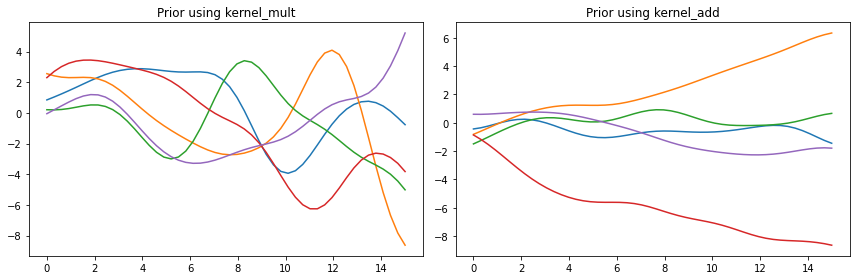

In [4]:
def kernel_mult(x, y, param):
    return kernel_rbf(x, y, param) * kernel_linear(x, y, param)

def kernel_add(x, y, param):
    return kernel_rbf(x, y, param) + kernel_linear(x, y, param)


# Priors using multiplication and addition of RBF and linear kernel
plt.figure(figsize=(12, 4))

for i, kernel in enumerate([kernel_mult, kernel_add]):
    # compute mean and covariance
    mu_prior = np.zeros(X_s.shape)
    cov_prior = kernel(X_s, X_s, params)
    # sample 5 normals from GP prior and plot
    f_prior = np.random.multivariate_normal(mu_prior.ravel(), cov_prior, 5)
    plt.subplot(1, 2, (i+1))
    for sample in f_prior:
        plt.plot(X_s, sample, lw=1.5, ls='-')
        #plt.axis([0, 15, -3, 3])
        plt.title(f'Prior using {kernel.__name__}')

plt.tight_layout()        
plt.show()


## Observations

Now we want to incorporate knowledge from collected **training data**. First, we assume that we obtained perfect measurements and have *noise-free* observations. We get the training set $\{(x_i,f_i)|i=1,...,n\}$, consisting of inputs $X$ and function outputs $f$. 
Given our test set $X_*$ and our training data $\{X,~ f\}$, we want to predict the function outputs $f_*$. 


The *joint distribution* of training and test outputs is: $\begin{bmatrix} f \\ f_* \end{bmatrix} \sim \mathcal{N} \begin{pmatrix} \begin{bmatrix} \mu \\ \mu_* \end{bmatrix}, \begin{bmatrix} \Sigma & \Sigma_* \\ \Sigma_*^T & \Sigma_{**} \end{bmatrix} \end{pmatrix} $,  

where $\Sigma$ denotes the covariance matrix evaluated at all paris of training points $X$, $\Sigma_*$ at training and test points, and $\Sigma_{**}$ at test points $X_*$, and $\mu=\mu_*=0$.  

The **posterior distribution** $p(f_*|X_*,X,f)$ can be derived by *conditioning* the joint Gaussian prior distributions on the observations. We get:  

\begin{align}
f_*|X_*,X,f \sim \mathcal{N}(\Sigma_*^T \Sigma^{-1}f,~ \Sigma_{**} - \Sigma_*^T \Sigma^{-1} \Sigma_*) 
\label{eq:post}\tag{1}
\end{align}

The function values $f_*$ can be sampled from the joint posterior distribution by evaluating the mean and covariance matrix and generating samples. 


We have data for bee colonies of size $n=2, 3, 5, 10$ available. Below you can see the respective histograms we got after the experiments.

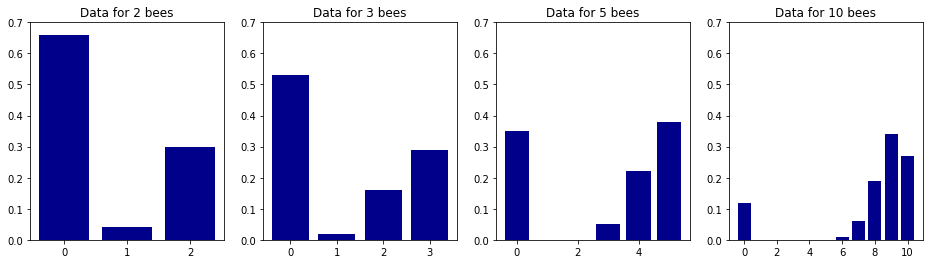

In [5]:
# observations for 2, 3, 5, and 10 bees
colony_sizes = [2, 3, 5, 10]
observations = [(0.66, 0.04, 0.3), 
                (0.53, 0.02, 0.16, 0.29),
                (0.35, 0.0, 0.0, 0.05, 0.22, 0.38),
                (0.12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.06, 0.19, 0.34, 0.27)]

plt.figure(figsize=(16, 4))

for i, size in enumerate(colony_sizes):
    obs = observations[i]
    idx = np.arange(size+1)
    plt.subplot(1,4,(i+1))
    plt.bar(idx, obs, 0.8, color="darkblue")
    plt.yticks(np.arange(0, 0.71, 0.1))
    plt.title(f'Data for {size} bees')

plt.show()

For a colony of size $n$, we have $n+1$ possible outcomes $o=(0,1,...,n) \in \mathbb{N}^{n+1}$ with the associated probabilities $p=(p_0,...,p_n) \in \mathbb{R}^{n+1}$.  
Since it is difficult to process and predict a whole distribution, we start by computing only the first statistical moment of the histogram, its mean value,   

$$\overline{x} = \sum_i (p_io_i).$$   

Therefore, our training data consists of inputs (colony size) $X=[2,3,5,10]$ and outputs (mean value) $f=[0.64,1.21,2.93,7.76]$.  
We now sample from the GP posterior after conditioning on the four mentioned observations. The shaded area represents the uncertainty as the $95\%$ confidence region (pointwise mean $\pm$ two times the standard deviation for each input value).  

Note that the variance is zero in a noise-free model, and that all functions go directly through the training points [2,5].

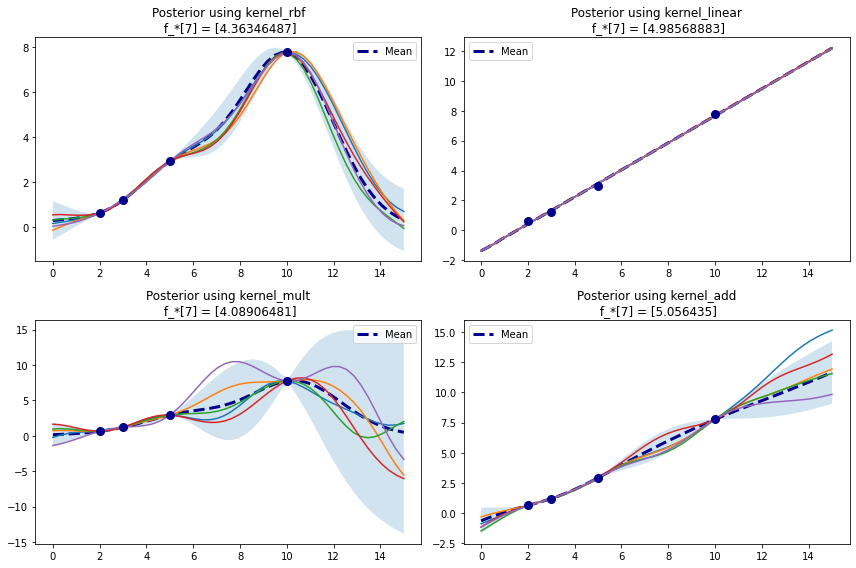

In [6]:
# computes mean vector mu_s and covariance matrix sigma_s for posterior distribution by applying equation (1)
# add a little noise to ensure that matrix is not singular
def posterior(X, X_s, f, kernel=kernel_rbf, params=params, noise=1e-2):
    cov = kernel(X, X, params) + noise**2 * np.eye(N)
    cov_s = kernel(X, X_s, params) + 1e-5 * np.eye(N,N_s)
    cov_ss = kernel(X_s, X_s, params) + 1e-5 * np.eye(N_s)
    
    mu_s = cov_s.T.dot(np.linalg.inv(cov)).dot(f)
    sigma_s = cov_ss - cov_s.T.dot(np.linalg.inv(cov)).dot(cov_s)
    
    return mu_s, sigma_s


# adapted from https://github.com/krasserm/bayesian-machine-learning/blob/dev/gaussian-processes/gaussian_processes_util.py
# to plot GPs with mean value and uncertainty area
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[], ax0=plt, pred=7):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
        
    ax0.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.2)
    ax0.plot(X, mu, '--', color='darkblue', lw=3, label='Mean')
    for i, sample in enumerate(samples):
        ax0.plot(X, sample, lw=1.5)
    if X_train is not None:
        ax0.plot(X_train, Y_train, 'o', ms=8, color='darkblue')
    ax0.legend()



# Noise free Training data
X = np.array([2,3,5,10]).reshape(-1,1)
N = len(X)
f = np.array([0.64,1.21,2.93,7.76]).reshape(-1,1)



# Poster using RBF and linear kernel, and multiplication and addition of both
plt.figure(figsize=(12, 8))

for i, kernel in enumerate([kernel_rbf, kernel_linear, kernel_mult, kernel_add]):
    # compute mean and covariance of the posterior distribution and draw 5 samples
    mu_post, cov_post = posterior(X, X_s, f, kernel, params)
    samples = np.random.multivariate_normal(mu_post.ravel(), cov_post, 5)
    idx_pred = np.absolute(X_s-7).argmin()
    plt.subplot(2,2,(i+1))
    plot_gp(mu_post, cov_post, X_s, X, f, samples)
    # compute prediction for x* = 7
    plt.title(f'Posterior using {kernel.__name__}\n f_*[7] = {mu_post[idx_pred]}')

plt.tight_layout()        
plt.show()




## Noisy Observations

Normally, we do not have perfect data, but some noise available due to measurement errors, for example. In this case, the training points are only approximated and the variance is not zero at those training points.   
If we assume that the observational noise is normally distributed, the posterior is still a GP and the inference analytically tractable. 
We assume $y = f(x) + \epsilon$ with $f \sim GP(0,\Sigma)$ and $\epsilon \sim \mathcal{N}(0, \sigma_f^2I)$. The noise variance $\sigma_f^2$ is an additional parameter of the likelihood and independently added to each observation. We get:  

$p(y|f) = \mathcal{N}(y|f,\sigma_f^2I).$  

We can then write the joint distribution of training and test values as  

$$ \begin{bmatrix} y \\ f_* \end{bmatrix} \sim \mathcal{N} \begin{pmatrix} 0, \begin{bmatrix} \Sigma_y & \Sigma_* \\ \Sigma_*^T & \Sigma_{**} \end{bmatrix} \end{pmatrix} $$

with $\Sigma_y := \Sigma + \sigma_f^2I$.

Again, we derive the conditional distribution and get  

$$ f_*|X_*,X,y \sim \mathcal{N}(\Sigma_*^T \Sigma_y^{-1} y,~ \Sigma_{**} - \Sigma_*^T\Sigma_y^{-1} \Sigma_* )$$

as our posterior distribution, from which we sample like in the example with noise-free training data. Below you can see the new predictions, if we assume $\sigma_f = 0.4$ [2,5].





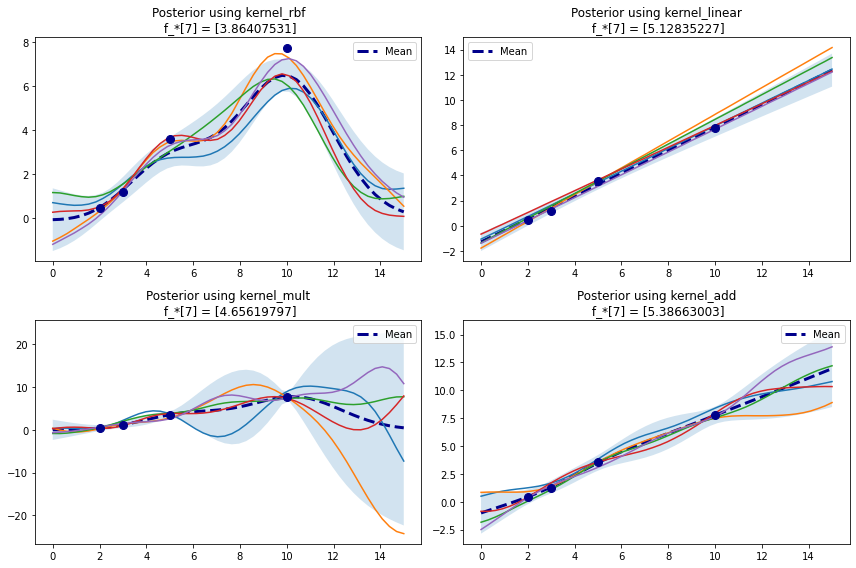

In [7]:
# assume noise
sigma_f = 0.4

# Noisy training data
X = np.array([2,3,5,10]).reshape(-1,1)
N = len(X)
f_noisy = np.array([0.64,1.21,2.93,7.76]).reshape(-1,1) + sigma_f * np.random.randn(*X.shape)


# define parameters for all kernels
params = {'var': 0.8,
          'ell': 2,        
          'var_b': 2,
          'off': 0.5}

# Poster using RBF and linear kernel, and multiplication and addition of both from noisy training data
plt.figure(figsize=(12, 8))

for i, kernel in enumerate([kernel_rbf, kernel_linear, kernel_mult, kernel_add]):
    # compute mean and covariance of the posterior distribution and draw 5 samples
    mu_post, cov_post = posterior(X, X_s, f_noisy, kernel, params, noise=sigma_f)
    samples = np.random.multivariate_normal(mu_post.ravel(), cov_post, 5)
    idx_pred = np.absolute(X_s-7).argmin()
    plt.subplot(2,2,(i+1))
    plot_gp(mu_post, cov_post, X_s, X, f_noisy, samples)
    # compute prediction for x* = 7
    plt.title(f'Posterior using {kernel.__name__}\n f_*[7] = {mu_post[idx_pred]}')

plt.tight_layout()        
plt.show()

# Next Steps

## 1 Optimize hyperparameters

We consider an empirical Bayes approach to maximize the marginal likelihood   

$$ p(y|X) = \int p(y|f,X)p(f|X)df$$
in order to optimize the kernel's hyperparameters.   

The marginal likelihood can be rewritten as   
\begin{align}
\text{log}~ p(y|X) = \text{log}~ \mathcal{N}(y|0,\Sigma_y) = - \frac{1}{2} y \Sigma_y^{-1}y - \frac{1}{2} \text{log}~ |\Sigma_y| - \frac{1}{2} N \text{log}~(2\pi),
\label{eq:post}\tag{2}
\end{align}

where the first term is a data fit term, the second term a model complexity term, and the third term a constant.  

Now we want to optimize the hyperparameters by minimizing the negative log marginal likelihood with respect to the kernel parameters [2,5]. 

0.8504763822250687 0.01 1.4766181278215849


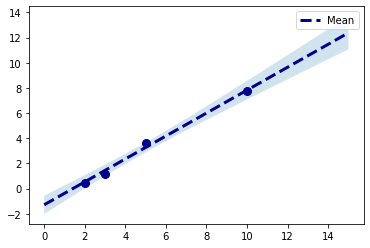

In [20]:
from scipy.optimize import minimize

# function that computes negative log marginal likelihood
def nll(X, f, kernel='rbf', noise=1e-2):
    
    f = f.ravel()
    
    # naive implementation of equation (2) for all kernels
    def nll_rbf(theta):
        params = {'var': theta[0],
                  'ell': theta[1]}  
        cov_y = kernel_rbf(X, X, params) + noise**2 * np.eye(N)
        return 0.5 * f.dot(np.linalg.inv(cov_y).dot(f)) + \
               0.5 * np.log(np.linalg.det(cov_y)) + \
               0.5 * N * np.log(2*np.pi)
    
    def nll_linear(theta):
        params = {'var': theta[0],
                  'var_b': theta[1],
                  'off': theta[2]}
        cov_y = kernel_linear(X, X, params) + noise**2 * np.eye(N)
        return 0.5 * f.dot(np.linalg.inv(cov_y).dot(f)) + \
               0.5 * np.log(np.linalg.det(cov_y)) + \
               0.5 * N * np.log(2*np.pi)
    
    def nll_mult(theta):
        params = {'var': theta[0],
                  'ell': theta[1],        
                  'var_b': theta[2],
                  'off': theta[3]}
        cov_y = kernel_mult(X, X, params) + noise**2 * np.eye(N)
        return 0.5 * f.dot(np.linalg.inv(cov_y).dot(f)) + \
               0.5 * np.log(np.linalg.det(cov_y)) + \
               0.5 * N * np.log(2*np.pi)
    
    def nll_add(theta):
        params = {'var': theta[0],
                  'ell': theta[1],        
                  'var_b': theta[2],
                  'off': theta[3]}
        cov_y = kernel_add(X, X, params) + noise**2 * np.eye(N)
        return 0.5 * f.dot(np.linalg.inv(cov_y).dot(f)) + \
               0.5 * np.log(np.linalg.det(cov_y)) + \
               0.5 * N * np.log(2*np.pi)
    
    
    if kernel == 'rbf':
        return nll_rbf
    elif kernel == 'lin':
        return nll_linear
    elif kernel == 'mult':
        return nll_mult
    else:
        return nll_add
    


res = minimize(nll(X, f_noisy, kernel='lin', noise=sigma_f), [1, 1, 1],
               bounds=((1e-2, None), (1e-2, None), (1e-2, None)),
               method='L-BFGS-B')

var_opt, var_b_opt, off_opt = res.x

print(var_opt, var_b_opt, off_opt)

params = {'var': var_opt,
          'ell': ell_opt,        
          'var_b': 2,
          'off': 0.5}


mu_s, cov_s = posterior(X, X_s, f_noisy, kernel_linear, params=params, noise=sigma_f)
plot_gp(mu_s, cov_s, X_s, X, f_noisy)

## 2 Multiple dimensions

# Compare with scikit's Gaussian Process Implementation [6]

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, RBF


gpr_l = GaussianProcessRegressor(kernel=DotProduct())
gpr_r = GaussianProcessRegressor(kernel=RBF())

X_s_ = np.linspace(0, 15, N_s)
X_ = np.array([2,3,5,10]).reshape(-1,1)
f_ = np.array([0.64,1.21,2.93,7.76])

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
y_mean_l, y_std_l = gpr_l.predict(X_s_[:, np.newaxis], return_std=True)
plt.plot(X_s_, y_mean_l, 'k', lw=3, zorder=9)
plt.fill_between(X_s_, y_mean_l - y_std_l, y_mean_l + y_std_l,
                     alpha=0.2, color='k')
y_samples_l = gpr_l.sample_y(X_s_[:, np.newaxis], 10)
plt.plot(X_s_, y_samples_l, lw=1)
plt.title("Prior linear kernel")

gpr_l.fit(X_,f_)

y_mean_l, y_std_l = gpr_l.predict(X_s_[:, np.newaxis], return_std=True)
plt.subplot(2, 2, 2)
plt.plot(X_s_, y_mean_l, 'k', lw=3, zorder=9)
plt.fill_between(X_s_, y_mean_l - y_std_l, y_mean_l + y_std_l,
                     alpha=0.2, color='k')
y_samples_l = gpr_l.sample_y(X_s_[:, np.newaxis], 10)
plt.plot(X_s_, y_samples_l, lw=1)
plt.scatter(X_[:, 0], f_, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.tight_layout()
plt.title("Posterior linear kernel")


plt.subplot(2, 2, 3)
y_mean_r, y_std_r = gpr_r.predict(X_s_[:, np.newaxis], return_std=True)
plt.plot(X_s_, y_mean_r, 'k', lw=3, zorder=9)
plt.fill_between(X_s_, y_mean_r - y_std_r, y_mean_r + y_std_r,
                     alpha=0.2, color='k')
y_samples_r = gpr_r.sample_y(X_s_[:, np.newaxis], 10)
plt.plot(X_s_, y_samples_r, lw=1)
plt.title("Prior RBF kernel")

gpr_r.fit(X_,f_)

y_mean_r, y_std_r = gpr_r.predict(X_s_[:, np.newaxis], return_std=True)
plt.subplot(2, 2, 4)
plt.plot(X_s_, y_mean_r, 'k', lw=3, zorder=9)
plt.fill_between(X_s_, y_mean_r - y_std_r, y_mean_r + y_std_r,
                     alpha=0.2, color='k')
y_samples_r = gpr_r.sample_y(X_s_[:, np.newaxis], 10)
plt.plot(X_s_, y_samples_r, lw=1)
plt.scatter(X_[:, 0], f_, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.tight_layout()
plt.title("Posterior RBF kernel")



plt.show()

# References

[1] Jochen  Görtler,  Rebecca  Kehlbeck,  and  Oliver  Deussen.   A  visual  exploration  of gaussian processes. Distill, 4:e17, 2019.  
[2] Kevin P. Murphy. Machine Learning: a probabilistic perspective.  MIT press, 2012.   
[3] Rasmussen, Carl Edward. Gaussian processes in machine learning. In Summer school on machine learning, Springer, 2003.  
[4] https://www.cs.toronto.edu/~duvenaud/cookbook/  
[5] https://krasserm.github.io/2018/03/19/gaussian-processes/  
[6] https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html